In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
from google.cloud import storage

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import os

In [6]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
import numpy as np

In [36]:
sc.setLogLevel("ERROR")

from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np


In [7]:
client = storage.Client()
bucket_name = 'my-project-bucket-jl'
bucket = client.get_bucket(bucket_name)
elements = bucket.list_blobs()
csv_files=[a.name for a in elements]

In [8]:
#gather data from cleaned folder
mlb_gameday_cleaned_list = []
for file in csv_files:
    filename = 'gs://my-project-bucket-jl/' + file + ''
    word = 'revised'
    if word not in filename: 
        continue 
    else: 
        df = filename
        mlb_gameday_cleaned_list.append(df)

In [9]:
mlb_gameday_list = []
for file in mlb_gameday_cleaned_list:
    try:
        filename = file 
        df = pd.read_parquet(filename)
        if df.empty:
            continue
        else:
            filename = file 
            print(filename)
            df = spark.read.parquet(filename)
            mlb_gameday_list.append(df)
    except pd.errors.EmptyDataError:
        continue

gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_04


gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2005_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_04
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2006_10

gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2018_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2018_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_03
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_04
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_05
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_06
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_09
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2019_10
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_07
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_08
gs://my-project-bucket-jl/cleaned/revised_mlb_gameday_pitch_sequence_2020_09

In [10]:
#merge individual yearly dataframes into one
merged_mlb_gameday_list_df = None
for df in mlb_gameday_list: 
    if merged_mlb_gameday_list_df == None: 
        merged_mlb_gameday_list_df = df 
    else: 
        merged_mlb_gameday_list_df = merged_mlb_gameday_list_df.union(df)

In [12]:
new_merged_mlb_gameday_list_df = merged_mlb_gameday_list_df.fillna(0)

In [20]:
#find all unique values in events column
for row in unique_names:
    print(row.events)

double_play
home_run
strikeout_double_play
double
walk
grounded_into_double_play
sac_fly_double_play
hit_by_pitch
intent_walk
fielders_choice
field_out
fielders_choice_out
sac_bunt
strikeout
triple
single
force_out
truncated_pa
catcher_interf
field_error
sac_fly
triple_play
sac_bunt_double_play
None


In [13]:
#categorize outcomes in events into if the batter got on base, if the at bat continues,
#or if the batter got out
got_on_base = ['single','home_run','double','walk',
               'hit_by_pitch','triple','catcher_interf',
               'fielders_choice','field_error','intent_walk']
at_bat_continues = [None,'truncated_pa','injury',
                    'ejection','game_advisory']
out = ['field_out','strikeout','sac_fly','grounded_into_double_play',
       'force_out','sac_bunt','fielders_choice_out','double_play',
       'strikeout_double_play','triple_play', 'sac_fly_double_play', 
       'sac_bunt_double_play','strikeout_triple_play']

#create user-defined function in order to apply the categories to the events column where if 
#at bat continues the function returns a 1, if the batter is out, the function returns a 0, and 
#if the batter got on base, the function returns a 2
def events_outcome(x):
    if x in at_bat_continues: 
        return 1
    elif x in out:
        return 0
    elif x in got_on_base:
        return 2
events_outcome_udf = udf(events_outcome)


In [14]:
#apply the user defined function to events column to create new column event_outcome
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn('event_outcome',events_outcome_udf('events'))

In [15]:
#create new column of boolean results of on_1b column where if runner on base, returns a 1
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_1b", when(new_merged_mlb_gameday_list_df.on_1b == 0.0, 0.0).otherwise(1.0) )

In [16]:
#create new column of boolean results of on_2b column where if runner on base, returns a 1
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_2b", when(new_merged_mlb_gameday_list_df.on_2b == 0.0, 0.0).otherwise(1.0) )

In [17]:
#create new column of boolean results of on_3b column where if runner on base, returns a 1
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("player_on_3b", when(new_merged_mlb_gameday_list_df.on_3b == 0.0, 0.0).otherwise(1.0) )

In [18]:
#create label where if pitch type is FF, returns a 1, and if not return a 0
new_merged_mlb_gameday_list_df = new_merged_mlb_gameday_list_df.withColumn("label",when(new_merged_mlb_gameday_list_df.pitch_type == "FF", 1.0).otherwise(0.0) )

In [18]:
new_merged_mlb_gameday_list_df.printSchema()

root
 |-- pitch_type: string (nullable = true)
 |-- batter: double (nullable = false)
 |-- pitcher: double (nullable = false)
 |-- events: string (nullable = true)
 |-- zone: double (nullable = false)
 |-- stand: string (nullable = true)
 |-- p_throws: string (nullable = true)
 |-- type: string (nullable = true)
 |-- balls: double (nullable = false)
 |-- strikes: double (nullable = false)
 |-- game_year: double (nullable = false)
 |-- on_3b: double (nullable = false)
 |-- on_2b: double (nullable = false)
 |-- on_1b: double (nullable = false)
 |-- outs_when_up: double (nullable = false)
 |-- inning: double (nullable = false)
 |-- inning_topbot: string (nullable = true)
 |-- game_pk: double (nullable = false)
 |-- at_bat_number: double (nullable = false)
 |-- pitch_number: double (nullable = false)
 |-- home_score: double (nullable = false)
 |-- away_score: double (nullable = false)
 |-- post_away_score: double (nullable = false)
 |-- post_home_score: double (nullable = false)
 |-- event

In [20]:
indexer = StringIndexer(inputCols=["batter", "pitcher",'stand','p_throws','type',
                                   'inning_topbot','game_pk','event_outcome',
                                   'game_year'], 
                        outputCols=["batterIndex", 
                                    "pitcherIndex",'standIndex','p_throwsIndex',
                                    'typeIndex','inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                       handleInvalid= "skip")

In [21]:
encoder = OneHotEncoder(inputCols=["batterIndex","pitcherIndex",'standIndex',
                                   'p_throwsIndex','typeIndex',
                                    'inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                        outputCols=["batterVector","pitcherVector",'standVector',
                                    'p_throwsVector','typeVector',
                                    'inning_topbotVector','game_pkVector',
                                    'event_outcomeVector','game_yearVector'],
                        dropLast=False)


In [22]:
assembler = VectorAssembler(inputCols=["batterVector","pitcherVector",'standVector',
                                       'p_throwsVector','typeVector','inning_topbotVector',
                                       'game_pkVector','event_outcomeVector','game_yearVector',
                                       'zone','balls', 'strikes','outs_when_up','inning',
                                       'at_bat_number','pitch_number','home_score','away_score',
                                       'post_away_score','post_home_score','player_on_1b',
                                       'player_on_2b','player_on_3b'], 
                            outputCol="features")


In [23]:
pitch_type_pipe = Pipeline(stages=[indexer, encoder, assembler])


In [24]:
transformed_sdf = pitch_type_pipe.fit(new_merged_mlb_gameday_list_df).transform(new_merged_mlb_gameday_list_df)


24/11/15 21:22:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
24/11/15 21:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1554.4 KiB


In [26]:
transformed_sdf.printSchema()

root
 |-- pitch_type: string (nullable = true)
 |-- batter: double (nullable = false)
 |-- pitcher: double (nullable = false)
 |-- events: string (nullable = true)
 |-- zone: double (nullable = false)
 |-- stand: string (nullable = true)
 |-- p_throws: string (nullable = true)
 |-- type: string (nullable = true)
 |-- balls: double (nullable = false)
 |-- strikes: double (nullable = false)
 |-- game_year: double (nullable = false)
 |-- on_3b: double (nullable = false)
 |-- on_2b: double (nullable = false)
 |-- on_1b: double (nullable = false)
 |-- outs_when_up: double (nullable = false)
 |-- inning: double (nullable = false)
 |-- inning_topbot: string (nullable = true)
 |-- game_pk: double (nullable = false)
 |-- at_bat_number: double (nullable = false)
 |-- pitch_number: double (nullable = false)
 |-- home_score: double (nullable = false)
 |-- away_score: double (nullable = false)
 |-- post_away_score: double (nullable = false)
 |-- post_home_score: double (nullable = false)
 |-- event

In [ ]:
feature_data =  'gs://my-project-bucket-jl/trusted/pitch_type_FF_logical_regression_model'
transformed_sdf.write().overwrite().save(feature_data)

In [28]:
new_merged_mlb_gameday_list_df.printSchema()

root
 |-- pitch_type: string (nullable = true)
 |-- batter: double (nullable = false)
 |-- pitcher: double (nullable = false)
 |-- events: string (nullable = true)
 |-- zone: double (nullable = false)
 |-- stand: string (nullable = true)
 |-- p_throws: string (nullable = true)
 |-- type: string (nullable = true)
 |-- balls: double (nullable = false)
 |-- strikes: double (nullable = false)
 |-- game_year: double (nullable = false)
 |-- on_3b: double (nullable = false)
 |-- on_2b: double (nullable = false)
 |-- on_1b: double (nullable = false)
 |-- outs_when_up: double (nullable = false)
 |-- inning: double (nullable = false)
 |-- inning_topbot: string (nullable = true)
 |-- game_pk: double (nullable = false)
 |-- at_bat_number: double (nullable = false)
 |-- pitch_number: double (nullable = false)
 |-- home_score: double (nullable = false)
 |-- away_score: double (nullable = false)
 |-- post_away_score: double (nullable = false)
 |-- post_home_score: double (nullable = false)
 |-- event

In [23]:
#training data and test data
trainingData, testData = new_merged_mlb_gameday_list_df.randomSplit([0.75, 0.25], seed=42)


In [24]:
#pipeline individual parts
indexer = StringIndexer(inputCols=["batter", "pitcher",'stand','p_throws','type',
                                   'inning_topbot','game_pk','event_outcome',
                                   'game_year'], 
                        outputCols=["batterIndex", 
                                    "pitcherIndex",'standIndex','p_throwsIndex',
                                    'typeIndex','inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                       handleInvalid= "skip")
encoder = OneHotEncoder(inputCols=["batterIndex","pitcherIndex",'standIndex',
                                   'p_throwsIndex','typeIndex',
                                    'inning_topbotIndex','game_pkIndex',
                                    'event_outcomeIndex','game_yearIndex'],
                        outputCols=["batterVector","pitcherVector",'standVector',
                                    'p_throwsVector','typeVector',
                                    'inning_topbotVector','game_pkVector',
                                    'event_outcomeVector','game_yearVector'],
                        dropLast=False)

assembler = VectorAssembler(inputCols=["batterVector","pitcherVector",'standVector',
                                       'p_throwsVector','typeVector','inning_topbotVector',
                                       'game_pkVector','event_outcomeVector','game_yearVector',
                                       'zone','balls', 'strikes','outs_when_up','inning',
                                       'at_bat_number','pitch_number','home_score','away_score',
                                       'post_away_score','post_home_score','player_on_1b',
                                       'player_on_2b','player_on_3b'], 
                            outputCol="features")
lr = LogisticRegression(maxIter=5)


In [25]:
pitch_type_pipe = Pipeline(stages=[indexer, encoder, assembler, lr])
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])
grid = grid.build()
print('Number of models to be tested: ', len(grid))
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
cv = CrossValidator(estimator=pitch_type_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)                

Number of models to be tested:  18


In [ ]:
cv  = cv.fit(trainingData)

24/12/13 02:46:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/13 02:47:14 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/12/13 02:48:04 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
24/12/13 02:48:17 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
24/12/13 02:48:23 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:48:44 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:48:48 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:49:05 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:49:06 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:49:14 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 02:49:15 WARN DAGScheduler: 

24/12/13 03:09:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:09:43 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:09:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:09:59 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:07 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:08 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:16 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:17 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:25 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:26 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:33 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/12/13 03:10:35 WARN DAGScheduler: Broadcasting larg

In [33]:
predictions = cv.transform(testData)
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

24/11/16 04:15:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


AUC: 0.7961624286122574


In [31]:
#creating the confusion matrix for the model (cm)
predictions.groupby('label').pivot('prediction').count().fillna(0).sort('label').show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

24/11/16 02:03:18 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/11/16 02:04:09 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:04:09 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:04:11 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:04:23 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/11/16 02:04:59 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:05:01 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


+-----+------+------+
|label|   0.0|   1.0|
+-----+------+------+
|  0.0|553855| 79666|
|  1.0|157558|129956|
+-----+------+------+



24/11/16 02:05:14 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/11/16 02:05:48 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:05:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:05:50 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:06:02 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/11/16 02:06:36 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/16 02:06:37 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


In [32]:
def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )

Accuracy, Precision, Recall, F1 Score
(0.2575624161948243, 0.3800459875394758, 0.12575115899867564, 0.18897387513150202)


24/11/16 02:07:38 ERROR TransportResponseHandler: Still have 1 requests outstanding when connection from /10.128.0.15:38230 is closed
24/11/16 02:07:38 ERROR TransportClient: Failed to send RPC RPC 6681539862902354010 to /10.128.0.15:38230: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException: null
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source) ~[netty-transport-4.1.100.Final.jar:4.1.100.Final]
24/11/16 02:07:38 WARN NettyRpcEnv: Ignored failure: java.io.IOException: Failed to send RPC RPC 6681539862902354010 to /10.128.0.15:38230: io.netty.channel.StacklessClosedChannelException
24/11/16 02:07:38 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 3916 from block manager BlockManagerId(8, cluster-7b8b-w-0.us-central1-f.c.mlb-pitch-sequence.internal, 38247, None)
java.io.IOException: Connection from /10.128.0.15:38230 closed
	at org.apache.spark.network.client.TransportResponse

LogisticRegression_c1b9bdd2d83d__aggregationDepth 2
LogisticRegression_c1b9bdd2d83d__elasticNetParam 1.0
LogisticRegression_c1b9bdd2d83d__family auto
LogisticRegression_c1b9bdd2d83d__featuresCol features
LogisticRegression_c1b9bdd2d83d__fitIntercept True
LogisticRegression_c1b9bdd2d83d__labelCol label
LogisticRegression_c1b9bdd2d83d__maxBlockSizeInMB 0.0
LogisticRegression_c1b9bdd2d83d__maxIter 5
LogisticRegression_c1b9bdd2d83d__predictionCol prediction
LogisticRegression_c1b9bdd2d83d__probabilityCol probability
LogisticRegression_c1b9bdd2d83d__rawPredictionCol rawPrediction
LogisticRegression_c1b9bdd2d83d__regParam 0.0
LogisticRegression_c1b9bdd2d83d__standardization True
LogisticRegression_c1b9bdd2d83d__threshold 0.5
LogisticRegression_c1b9bdd2d83d__tol 1e-06


24/11/16 02:07:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


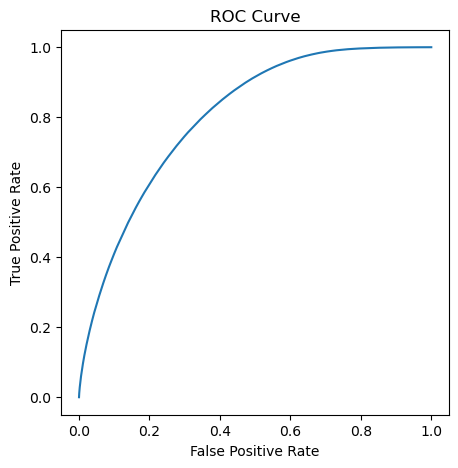

In [33]:
#find the parameters of the best model
parammap = cv.bestModel.stages[3].extractParamMap()

for p, v in parammap.items():
    print(p, v)

mymodel = cv.bestModel.stages[3]

plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

In [34]:
#finding the hyperparameters of the best model
hyperparams = cv.getEstimatorParamMaps()[np.argmax(cv.avgMetrics)]
# Print it out
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

(Param(parent='LogisticRegression_c1b9bdd2d83d', name='regParam', doc='regularization parameter (>= 0).'), 0.0)
(Param(parent='LogisticRegression_c1b9bdd2d83d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 1.0)


In [36]:
coeff = mymodel.coefficients.toArray().tolist()

In [44]:
coefficients = mymodel.coefficients
print("bestModel coefficients", coefficients)
intercept = mymodel.intercept
print("bestModel intercept", intercept)


bestModel coefficients [0.004822924110543569,0.05054315910817749,-0.07874601513749556,-0.1607729086529294,0.05180356594847683,0.04170626964368799,-0.08310623121505707,0.02768028044004801,-0.16207194413232687,-0.15289582282910436,0.06002733237528129,0.04587214911043095,-0.19678744369093604,-0.03883998911124643,0.11929603545686396,-0.07170947416833644,-0.3215340651164719,0.014433603202503139,-0.12855229010050995,-0.03349198069694512,-0.17608566656455577,-0.0017008214930123806,-0.15769133434986757,0.138876566139447,0.013074797844007903,-0.06806527447231628,-0.04042664103299345,-0.22302380210722364,0.23916364426899958,-0.027362253742053633,0.3184172465760968,-0.21771092431966757,-0.17151117262420174,-0.24232275045969456,-0.08588833558360237,-0.23389810533490607,-0.20608567356342708,-0.11611199820893427,-0.06942580532523063,-0.057364728274863414,-0.156306623305513,-0.20314943273454922,0.07396036417488336,0.007302949272675518,-0.17460943118131925,-0.12701070778835902,-0.10390585817429646,-0.

In [39]:
bestModel = cv.bestModel

In [41]:
model_path =  'gs://my-project-bucket-jl//models/pitch_type_FF_logical_regression_model'
bestModel.write().overwrite().save(model_path)